In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *

In [4]:
df = pd.read_csv('cars_data.csv')
df.head()   

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,G Class,2020,159999,Semi-Auto,1350,Petrol,145,21.4,4.0,Mercedes-Benz
1,G Class,2020,154998,Automatic,3000,Petrol,150,21.4,4.0,Mercedes-Benz
2,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2,Mercedes-Benz
3,R8,2020,145000,Semi-Auto,2000,Petrol,145,21.1,5.2,Audi
4,A Class,2019,140319,Semi-Auto,785,Petrol,150,22.1,4.0,Mercedes-Benz


Для корректной обработки уберём пропуски. В числовых столбцах пропуски заменим на средние значения, а строки, в которых пропущены значения строкового типа - удалим(иначе могут появиться некорректные данные):

In [21]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.mean()))

string_cols = df.select_dtypes(include=['object']).columns
df = df.dropna(subset=string_cols)

df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,G Class,2020,159999,Semi-Auto,1350,Petrol,145,21.4,4.0,Mercedes-Benz
1,G Class,2020,154998,Automatic,3000,Petrol,150,21.4,4.0,Mercedes-Benz
2,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2,Mercedes-Benz
3,R8,2020,145000,Semi-Auto,2000,Petrol,145,21.1,5.2,Audi
4,A Class,2019,140319,Semi-Auto,785,Petrol,150,22.1,4.0,Mercedes-Benz


In [5]:
dfcopy = df
dfcopy.describe()

,year,price,mileage,tax,mpg,engineSize
count,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000
mean,2017.066502,16773.487555,23219.475499,120.142408,55.205623,1.664913
std,2.118661,9868.552222,21060.882301,63.357250,16.181659,0.558574
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7673.000000,125.000000,47.100000,1.200000
50%,2017.000000,14470.000000,17682.500000,145.000000,54.300000,1.600000
75%,2019.000000,20750.000000,32500.000000,145.000000,62.800000,2.000000
max,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


Стоит проверить гипотезы о логнормальном распределении цен автомобилей, годов производства и расходе топлива.

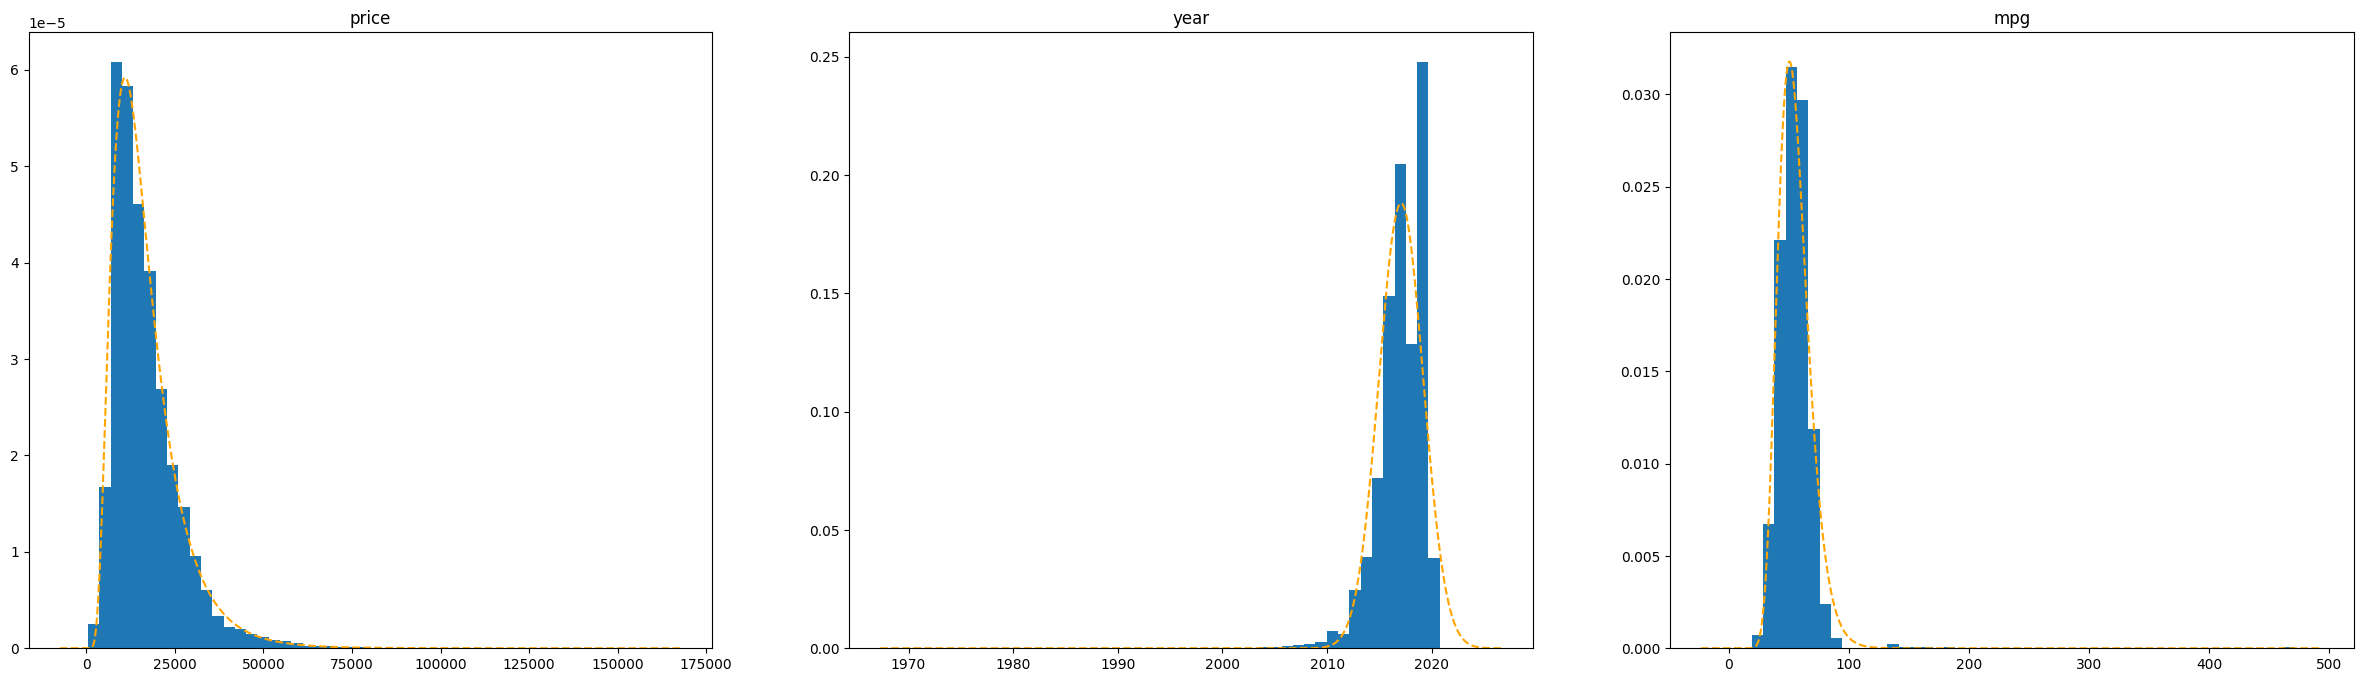

In [ ]:
keys = ['price', 'year', 'mpg']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(10 * len(keys), 8)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=50)
    
    shape, loc, scale = stats.lognorm.fit(df[key], floc=0) 
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.lognorm.pdf(x, shape, loc=loc, scale=scale) # плотность вероятности (частота встречаемости)
    
    ax.plot(x, y, linestyle='dashed', color='orange')
    ax.set_title(key)

plt.show()


График цены имеет достаточно длинный "хвост" вправо, что характерно для большинства графиков цен. Если рассматривать график годов производства, то здесь уже "хвост" влево ввиду того, что чем ближе к настоящему времени, тем больше производится автомобилей. Также для интереса проверим распределение расхода топлива так же на лог. нормальное распределение.

Построим Q-Q кривые для проверки того, следуют ли распределения данных лог. нормальному распределению.

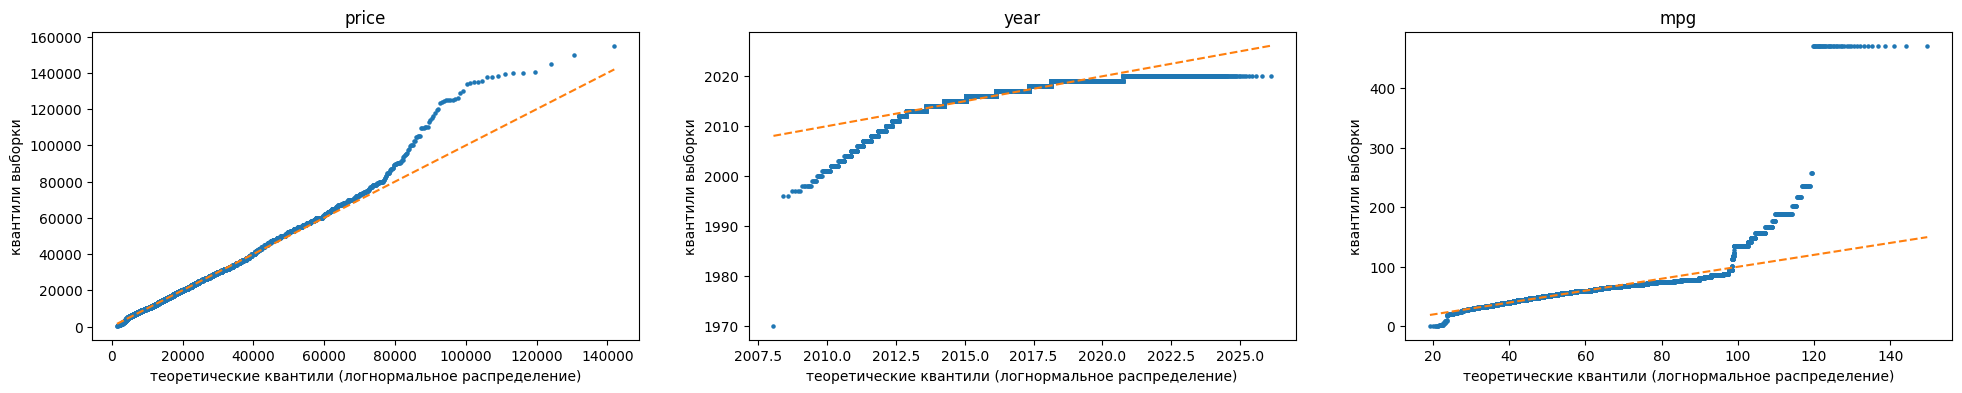

In [ ]:
keys = ['price', 'year', 'mpg']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = df[key]
    
    shape, loc, scale = stats.lognorm.fit(samples, floc=0)
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.lognorm.ppf(interval, shape, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5) # график рассеяния, x - теоретические, y - эмпирические
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили (логнормальное распределение)')
    ax.set_ylabel('квантили выборки')

plt.show()


Если данные следуют лог. нормальному распределению, точки на Q-Q графике будут лежать вдоль прямой линии. Отклонения от этой прямой показывают, что распределения данных отличаются от лог. нормального. На основе этой проверки, делаем вывод о том, что цена, год производства и расход топлива не распределены лог. нормально. Однако цена ближе всех к лог. нормальному распределению.

In [84]:
for key in keys:
    print(key)
    
    samples = np.log(df[key])

    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

price
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6867938431308335
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9577226952677256
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9931942852464385

year
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8664340101522843
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9757655149828066
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9866648927460292

mpg
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7407380874406418
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.966135172752579
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9911781562141805



Данный анализ статистических показателей для выборок позволяет сделать вывод о том, что цена распределена лог. нормально, так как в этом случае расчётные цифры близки к теоретическим.
Подытоживая результаты, полученные относительно годов производства - мы не можем сделать вывод о лог. нормальном распределении. Это означает, что в определённые года производилось большее кол-во автомобилей, например, исходя из графика, видим, что в 2017 и 2019 производилось много больше автомобилей, нежели в 2018. Это может быть связано с проблемами внутри компаний-производителей, либо наша выборка нерепрезентативна и значения в ней не соответствовали условиям представительности выборки(неравномерный отбор или отбор не случаен).
Что касается расхода топлива, здесь тоже не можем сделать вывод о лог. нормальности распределения.

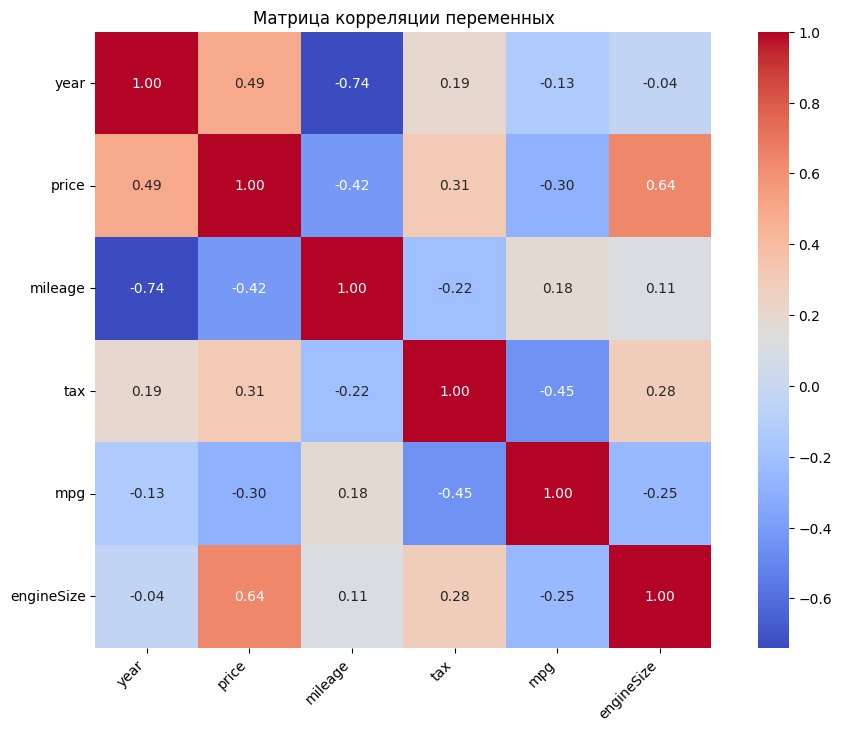

In [90]:

numeric_columns = df.select_dtypes(include=['number'])
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title('Матрица корреляции переменных')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

На основе построенной корреляционной матрицы можно сделать некоторые выводы и понять, что исследовать далее.

Выводы:
1. Корреляция между year и mileage: Высокий отрицательный коэффициент корреляции (-0.74): более новые автомобили(> year) обычно имеют меньший пробег (mileage). Логично: новые автомобили еще не успевают проехать большие расстояния.

2. Корреляция между price и engineSize: Высокий положительный коэффициент корреляции (0.64): автомобили с бОльшими двигателями (engineSize) имеют тенденцию быть более дорогими (price). Гипотеза: более мощные и крупные двигатели чаще всего в дорогих автомобилях.

3. Корреляция между price и year: Положительный коэффициент корреляции (0.49) указывает на то, что более новые автомобили, как правило, имеют более высокую стоимость. Гипотеза: старые автомобили обычно дешевеют со временем.

Проверим наличие зависимости между пробегом и годом выпуска

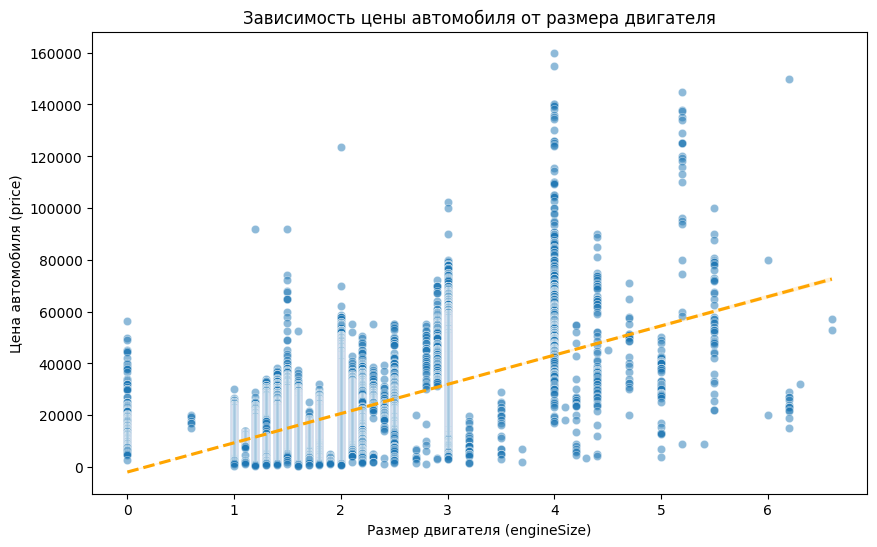

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='engineSize', y='price', alpha=0.5) # диаграмма рассеяния 
sns.regplot(data=df, x='engineSize', y='price', scatter=False, color='orange', line_kws={'linestyle':'dashed'}) # линия регрессии
plt.title("Зависимость цены автомобиля от размера двигателя")
plt.xlabel("Размер двигателя (engineSize)")
plt.ylabel("Цена автомобиля (price)")
plt.show()

- На графике можно наблюдать возрастающий тренд (оранжевая пунктирная линия), что подтверждает гипотезу о том,
что цена автомобиля увеличивается с увеличением размера двигателя.
Однако из-за разброса данных вокруг линии тренда можно видеть, что зависимость не является идеальной
и существуют другие факторы, которые влияют на цену.

### Статистический тест 
H0: средних пробег новых автомобилей меньше старых

In [10]:
import scipy.stats as stats

new_cars_mileage = df[df['year'] >= 2015]['mileage']
old_cars_mileage = df[df['year'] < 2015]['mileage']

# используем U-критерий Манна-Уитни в силу не нормальности распределения данных
u_stat, p_value = stats.mannwhitneyu(new_cars_mileage, old_cars_mileage, alternative='less')

print("U-statistic:", u_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print(f"Нет оснований на уровне значимости {alpha} отвергать нулевую гипотезу: средний пробег новых автомобилей меньше.")
else:
    print(f"Отвергаем нулевую гипотезу на уровне значимости {alpha}: средний пробег новых автомобилей не меньше.")


U-statistic: 82283729.5
P-value: 0.0
Нет оснований на уровне значимости 0.05 отвергать нулевую гипотезу: средний пробег новых автомобилей меньше.


### Анализ распределения цен по маркам автомобилей и распределения цен в зависимости от года выпуска с помощью боксплотов

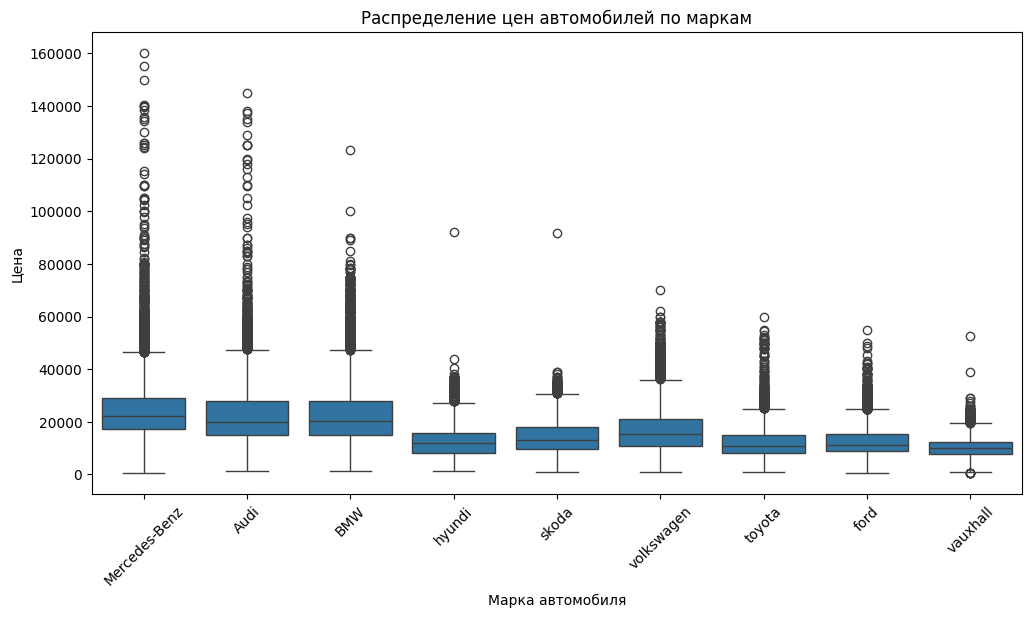

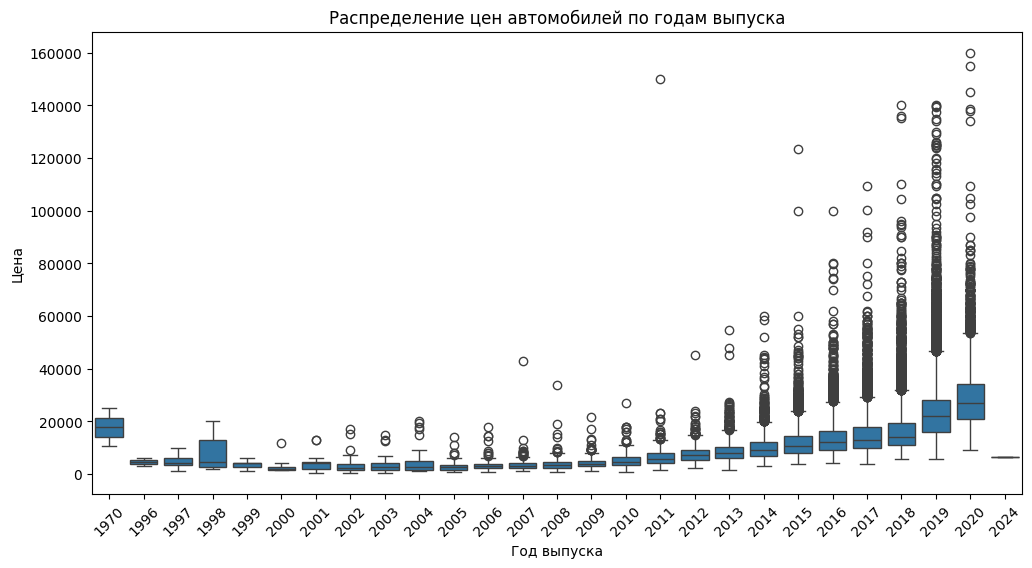

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Manufacturer', y='price')
plt.title("Распределение цен автомобилей по маркам")
plt.xlabel("Марка автомобиля")
plt.ylabel("Цена")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='year', y='price')
plt.title("Распределение цен автомобилей по годам выпуска")
plt.xlabel("Год выпуска")
plt.ylabel("Цена")
plt.xticks(rotation=45)
plt.show()


Выводы: 
1. Распределение цен автомобилей по маркам
- Mercedes-Benz, Audi, и BMW имеют более высокие цены по сравнению с другими марками,
  что отражается в более высоких медианах и разбросе данных. Эти марки имеют больше выбросов,
  что говорит о наличии очень дорогих моделей.
- Hyundai, Skoda, Volkswagen, Toyota, Ford и Vauxhall в целом имеют более низкую медианную цену
  и меньший разброс цен. Они ориентированы на массовый рынок и чаще имеют более низкую стоимость.
- Выбросы присутствуют у всех брендов, что свидетельствует о наличии как очень дорогих, так и доступных моделей у всех брендов(но в разном количестве)

2. Распределение цен автомобилей по годам выпуска
- Новые автомобили имеют тенденцию стоить дороже в силу инфляции и внедрения новых технологий,
  что подтверждает нашу гипотезу о том, что современные машины, как правило, дороже.
- Выбросы в более давних годах могут указывать на наличие раритетных или коллекционных автомобилей

### Анализ параметров законов распределения для автомобилей разных производителей

In [97]:
df_mercedes = df[df['Manufacturer'] == 'Mercedes-Benz']
df_skoda = df[df['Manufacturer'] == 'skoda']
df_ford = df[df['Manufacturer'] == 'ford']

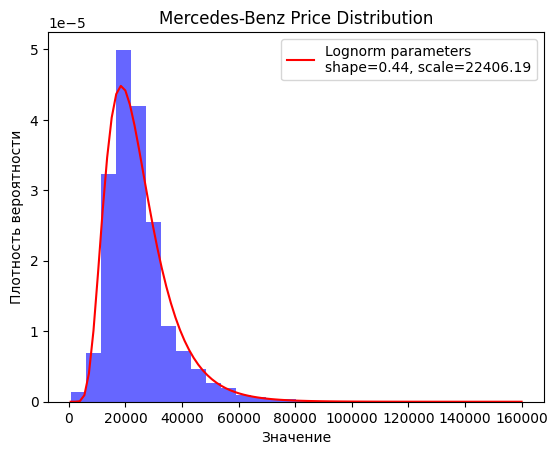

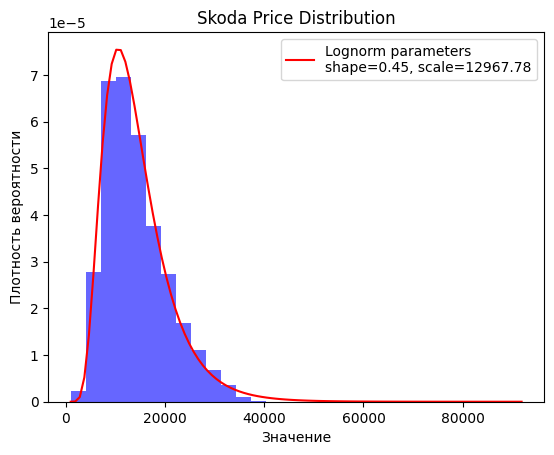

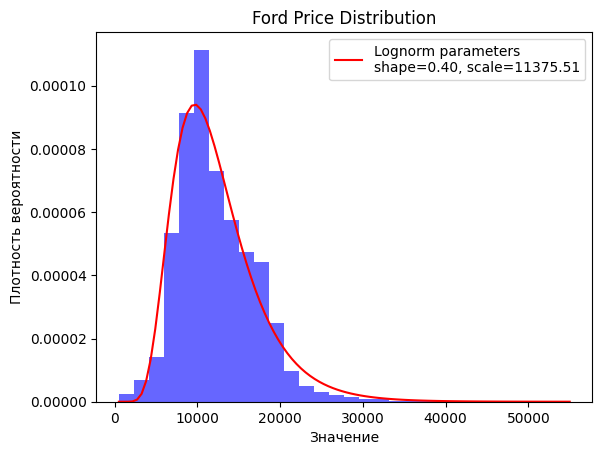

In [99]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(data, title):
    plt.hist(data, bins=30, density=True, alpha=0.6, color='blue')
    
    shape, loc, scale = stats.lognorm.fit(data, floc=0)
    
    x = np.linspace(min(data), max(data), 100)
    pdf = stats.lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, pdf, 'r-', label=f'Lognorm parameters\nshape={shape:.2f}, scale={scale:.2f}')
    
    plt.title(title)
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.show()
    return shape, loc, scale
    

shape, loc, scale = plot_distribution(df_mercedes['price'], 'Mercedes-Benz Price Distribution')
shape, loc, scale = plot_distribution(df_skoda['price'], 'Skoda Price Distribution')
shape, loc, scale = plot_distribution(df_ford['price'], 'Ford Price Distribution')
plt.show()

Для каждого бренда были определены два ключевых параметра логнормального распределения: shape и scale.
- shape - степень асимметрии
- scale - медиана распределения

Анализ логнормального распределения для каждого бренда позволяет понять, как цены распределяются для каждой марки:

- Mercedes-Benz имеет более высокий scale, что подтверждает, что автомобили этого бренда имеют более высокие средние цены.
- Skoda показывает бОльшую асимметрию (больший shape), что может указывать на значительное различие в ценах: от доступных моделей
  до более дорогих, но с меньшим количеством премиум-моделей, чем у Mercedes-Benz, и scale много меньший, чем у Mercedes-Benz - это указывает на то, что
  автомобили Skoda имеют меньшие средние цены.
- Ford имеет схожий с Skoda scale с меньшим значением shape, что указывает на немного более симметричное распределение цен.

## Общие выводы

1. Цена автомобилей распределена лог. нормально. Исследование параметров закона распределения(scale и shape) показало, что для дорогих автомобилей         параметры scale и shape выше, что указывает на большие цены и вариативность. Для обычных марок параметры ниже, что говорит о меньших колебаниях цен.
2. Рассмотрена зависимость цены автомобиля от различных параметров: от бренда, года выпуска, размера двигателя. Стоит отметить неочевидные факты,
   которые выяснились в ходе анализа матрицы корреляции:
   - расход топлива мало зависит/не зависит от размера/мощности двигателя
   - цена автомобиля не так сильно зависит от его пробега, как ожидалось
3. Распределение цен по брендам: премиальные бренды показывают высокие медианные цены и разброс, тогда как массовые бренды удерживают более доступные      цены с меньшими колебаниями
4. Цены по годам выпуска: Новые автомобили стоят значительно дороже из-за улучшенных технологий и стандартов, в то время как старые модели имеют           сниженные цены, за исключением редких коллекционных экземпляров